# 12. Implementing a Multilayer Artificial Neural Network from Scratch

In [1]:
import sys
import numpy as np
import scipy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import imageio
import IPython
import sklearn
import tensorflow as tf
import nltk

from IPython.display import Image
%matplotlib inline

import datetime
dt = datetime.datetime.now()

print(
"""{}-{:02d}-{:02d} {:02d}:{:02d}:{:02d}
----------------------
python\t\t{}.{}.{}
----------------------
numpy\t\t{}
scipy\t\t{}
pandas\t\t{}
matplotlib\t{}
imageio\t\t{}
----------------------
ipython\t\t{}
----------------------
sklearn\t\t{}
tensorflow\t{}
nltk\t\t{}"""
    .format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, 
            sys.version_info.major, sys.version_info.minor, sys.version_info.micro,
            np.__version__, 
            scipy.__version__, 
            pd.__version__, 
            matplotlib.__version__, 
            imageio.__version__,
            IPython.__version__, 
            sklearn.__version__, 
            tf.__version__,
            nltk.__version__))

c = {'b': '#1f77b4', #blue
     'o': '#ff7f0e', #orange
     'g': '#2ca02c', #green
     'r': '#d62728', #red
     'v': '#9467bd', #violet
     'br': '#8c564b', #brown
     'p': '#e377c2', #pink
     'gr': '#7f7f7f', #grey
     'y': '#bcbd22', #yellow
     'c': '#17becf'} #cyan

2019-12-30 14:01:47
----------------------
python		3.6.7
----------------------
numpy		1.16.2
scipy		1.1.0
pandas		0.25.1
matplotlib	3.1.1
imageio		2.5.0
----------------------
ipython		7.8.0
----------------------
sklearn		0.20.4
tensorflow	1.13.1
nltk		3.2.4


## 12.01. Modeling complex functions with artificial neural entworks

### 12.01.01. Single-layer neural network recap
### 12.01.02. Introducing the multilayer neural network architecture

### 12.01.03. Activating a neural network via forward propagation

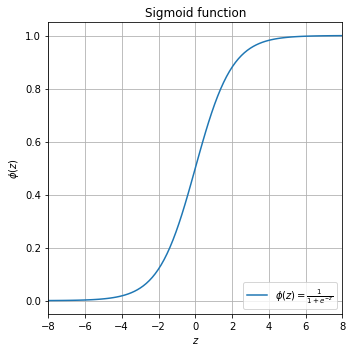

In [11]:
def phi(z):
    return 1 / (1 + np.exp(-z))

z0, z1 = -8, 8
z = np.linspace(z0, z1, 100)

fig, ax = plt.subplots(figsize=(5, 5), facecolor='w')
ax.set_facecolor('w')

ax.plot(z, phi(z), color=c['b'], label=r'$\phi (z) = \frac{1}{1 + e^{-z}}$')
ax.grid(True)
ax.legend(loc='lower right')
ax.set(title='Sigmoid function', xlabel=r'$z$', ylabel=r'$\phi(z)$')
ax.set_xlim(z0, z1)

plt.tight_layout()
# plt.savefig('fig/1204.png')
plt.show()

## 12.02. Classifying handwritten digits
### 12.02.01 Obtaining and preparing the MNIST dataset

In [9]:
import os
import struct
import numpy

def load_mnist(path, kind='train'):
    """Load MNIST data drom 'path'"""
    labels_path = os.path.join(path, 
                               '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images.idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 
                                                     784)
        images = ((images / 255.) - .5) * 2
        
    return images, labels

In [10]:
X_train, y_train = load_mnist('data', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


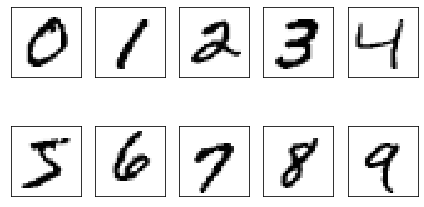

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, facecolor='w')

ax = ax.flatten()

for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

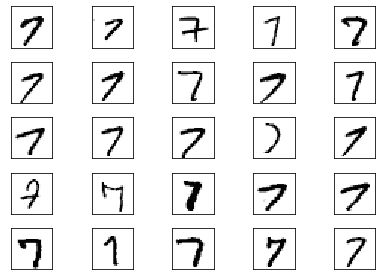

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, facecolor='w')

ax = ax.flatten()

for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [16]:
import numpy as np
np.savez_compressed('data/mnist_scaled.npz', 
                          X_train=X_train, 
                          y_train=y_train, 
                          X_test=X_test, 
                          y_test=y_test)

In [17]:
mnist = np.load('data/mnist_scaled.npz')

In [18]:
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [19]:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

### 12.02.02. Implementing a multilayer perceptron

In [20]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_examples]
            Target class labels.
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [21]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=.01, 
                  epochs=200,
                  eta=.0005,
                  minibatch_size=100,
                  shuffle=True,
                  seed=1)

In [22]:
nn.fit(X_train=X_train[:55000],
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:],)

200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98%  

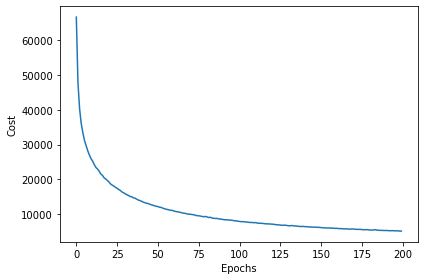

In [27]:
fig, ax = plt.subplots(facecolor='w')
ax.plot(range(nn.epochs), nn.eval_['cost'])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs')
plt.tight_layout()
plt.show()

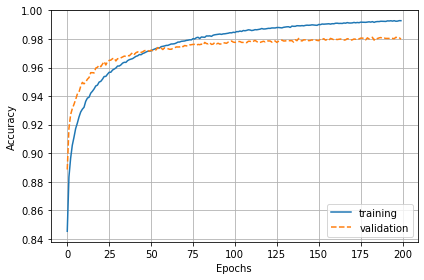

In [29]:
fig, ax = plt.subplots(facecolor='w')

ax.plot(range(nn.epochs), nn.eval_['train_acc'], label='training')
ax.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation', linestyle='--')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend(loc='lower right')
ax.grid(True)
plt.tight_layout()
plt.show()

## 12.03. Training an artificial neural network
### 12.03.01. Computing the  logistic cost function
### 12.03.02. Developing your understanding of backpropagation
### 12.03.03. Training neural networks via backpropagation
## 12.04. About the convergence in neural networks
## 12.05. A few last words about the neural network implementation
## 12.06. Summary

- [12.01. Modeling complex functions with artificial neural entworks][1201]
    - [12.01.01. Single-layer neural network recap][120101]
    - [12.01.02. Introducing the multilayer neural network architecture][120102]
    - [12.01.03. Activating a neural network via forward propagation][120103]
- [12.02. Classifying handwritten digits][1202]
    - [12.02.01 Obtaining and preparing the MNIST dataset][120201]
    - [12.02.02. Implementing a multilayer perceptron][120202]
- [12.03. Training an artificial neural network][1203]
    - [12.03.01. Computing the  logistic cost function][120301]
    - [12.03.02. Developing your understanding of backpropagation][120302]
    - [12.03.03. Training neural networks via backpropagation][120303]
- [12.04. About the convergence in neural networks][1204]
- [12.05. A few last words about the neural network implementation][1205]
- [12.06. Summary][1206]

[1201]: #1201-modeling-complex-functions-with-artificial-neural-entworks
[120101]: #120101-Single-layer-neural-network-recap
[120102]: #120102-Introducing-the-multilayer-neural-network-architecture
[120103]: #120103-Activating-a-neural-network-via-forward-propagation
[1202]: #1202-Classifying-handwritten-digits
[120201]: #120201-Obtaining-and-preparing-the-MNIST-dataset
[120202]: #120202-Implementing-a-multilayer-perceptron
[1203]: #1203-Training-an-artificial-neural-network
[120301]: #120301-Computing-the--logistic-cost-function
[120302]: #120302-Developing-your-understanding-of-backpropagation
[120303]: #120303-Training-neural-networks-via-backpropagation
[1204]: #1204-About-the-convergence-in-neural-networks
[1205]: #1205-A-few-last-words-about-the-neural-network-implementation
[1206]: #1206-Summary